In [167]:
##denpendents 
import os
import shutil
import random

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [188]:
##folder structures and directory
RAW_DIR = "data/raw"
OUT_DIR = "data"
BAD_DIR = "data/corrupt"

##image resize process
IMG_HIGHT=180    ##Resize all images
IMG_WIDTH=180   ##Resize all images
CHANNELS=3
BATCH_SIZE=32 
EPOCHS=10

##splitting ratio
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

## Data Loading using Tensorflow

In [175]:
##data loading 
raw_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    RAW_DIR,
    shuffle=True,
    image_size=(IMG_HIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 25170 files belonging to 22 classes.


In [178]:
##class name
class_name=raw_dataset.class_names
len(class_name)
class_name

['Cashew anthracnose',
 'Cashew gumosis',
 'Cashew healthy',
 'Cashew leaf miner',
 'Cashew red rust',
 'Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava green mite',
 'Cassava healthy',
 'Cassava mosaic',
 'Maize fall armyworm',
 'Maize grasshoper',
 'Maize healthy',
 'Maize leaf beetle',
 'Maize leaf blight',
 'Maize leaf spot',
 'Maize streak virus',
 'Tomato healthy',
 'Tomato leaf blight',
 'Tomato leaf curl',
 'Tomato septoria leaf spot',
 'Tomato verticulium wilt']

In [44]:
##Instead of deleting immediately, we can move it
#Move corrupted images to a separate folder 

def move_corrupted_images(image_dir, bad_dir):
    os.makedirs(bad_dir, exist_ok=True)

    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)
                    img.verify()
                except:
                    shutil.move(path, os.path.join(bad_dir, file))

In [ ]:
##move the corrupted files
move_corrupted_images(RAW_DIR,BAD_DIR)

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Hardcode: Splitting Raw Data</b></h2>

In [ ]:
##Reproducibility
SEED = 42
random.seed(SEED)

##Identify class labels
folder_name_list=os.listdir(RAW_DIR)

##Folder names become class labels
##keeps only folders ["apple", "mango", "grapes", "potato"]
classes = [cls for cls in folder_name_list if os.path.isdir(os.path.join(RAW_DIR, cls))] 

# Create directory structure
##Create output directory structure
##Iterates over dataset splits
for split in ["train", "val", "test"]:
    ##Iterates over class labels
    for clss in classes:
        os.makedirs(os.path.join(OUT_DIR, split, clss), exist_ok=True) #Creates directories

# Split per class
#Process one class at a time
#This ensures class-wise stratification
for cls in classes:
    #full path to one class folder like data/raw/apple
    cls_path = os.path.join(RAW_DIR, cls)
    ##list of images within list of folder 
    img_list=os.listdir(cls_path)
    #Collects only image files
    images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]

    ##image suffling
    random.shuffle(images)

    #Compute split sizes
    n_total = len(images)
    n_train = int(TRAIN_RATIO * n_total)
    n_val = int(VAL_RATIO * n_total)

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    #Copy images into split folders
    for img in train_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(OUT_DIR, "train", cls, img)
        )

    for img in val_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(OUT_DIR, "val", cls, img)
        )

    for img in test_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(OUT_DIR, "test", cls, img)
        )

print("Train / Validation / Test split completed.")

Train / Validation / Test split completed.


In [50]:
classes

['Cashew healthy',
 'Cashew anthracnose',
 'Cashew red rust',
 'Cassava mosaic',
 'Cashew leaf miner',
 'Cashew gumosis',
 'Maize leaf beetle',
 'Maize fall armyworm',
 'Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava healthy',
 'Maize healthy',
 'Maize grasshoper',
 'Tomato leaf blight',
 'Maize leaf blight',
 'Maize streak virus',
 'Tomato verticulium wilt',
 'Maize leaf spot',
 'Tomato leaf curl',
 'Cassava green mite',
 'Tomato healthy',
 'Tomato septoria leaf spot']

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Data Preprocessing: Converting images into an Array</b></h2>

In [ ]:
##data directories
TRAIN_DIR='data/train'
TEST_DIR='data/test'
VAL_DIR='data/val'

# Loads images from directories, automatically assigns labels from folder names
##output dataset format look like this (images,labels) in memory
train_ds = tf.keras.utils.image_dataset_from_directory( 
    TRAIN_DIR,
    image_size=(IMG_HIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,       # Shuffle training dataset
    seed=42,
    validation_split=False
)

##validation data preprocess
val_ds = tf.keras.utils.image_dataset_from_directory( 
    VAL_DIR,
    image_size=(IMG_HIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,       #shuffle is not needed for validation/test
    validation_split=False
)

##test data preprocess
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_HIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,    #shuffle is not needed for validation/test
    validation_split=False
)

Found 17609 files belonging to 22 classes.
Found 3764 files belonging to 22 classes.
Found 3797 files belonging to 22 classes.


In [52]:
##disease class
dis_class=train_ds.class_names

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Display Images</b></h2>

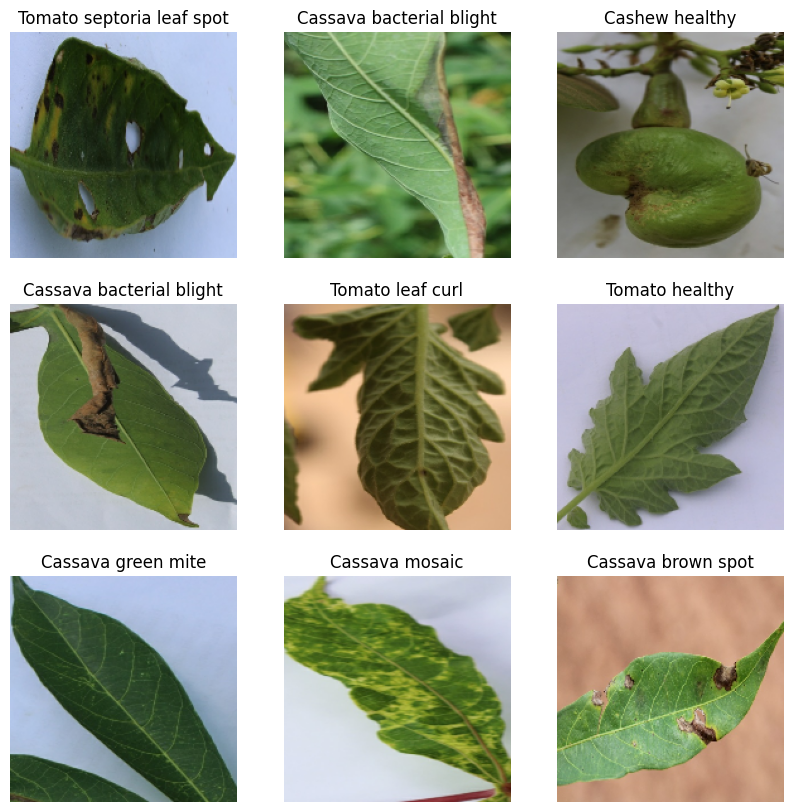

In [181]:
##print images from the train dataset
## taking 1st batch only take(1)

plt.figure(figsize=(10,10))
for image,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(np.array(image[i]).astype('uint8'))
        plt.title(dis_class[labels[i]])
        plt.axis("off")
plt.show()

In [165]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [170]:
for x, y in train_ds.take(1):
    print(type(x), x.shape)


<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 180, 180, 3)


## Alternative way to split data

In [189]:
len(raw_dataset)*TRAIN_RATIO

550.9

In [191]:
train=raw_dataset.take(550)
len(train)

550

In [192]:
rest_data=raw_dataset.skip(550)
len(rest_data)

237

In [193]:
len(raw_dataset)*VAL_RATIO

118.05

In [ ]:
len(raw_dataset)*TEST_RATIO

236

In [197]:
test=rest_data.take(118)
len(test)

118

In [198]:
val=rest_data.skip(118)
len(val)

119

In [ ]:
##user define function to perform data spliting
def train_test_partition(data, train_split=0.80, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=100):
   total_data= len(data)

   if shuffle:
      data = data.shuffle(shuffle_size, SEED)
    
   ## train, test, validation size based on the given data and splitting size
   train_size=int(total_data*train_split)
   val_size=int(total_data*val_split)
   
   ##splitted data
   train_set=data.take(train_size)
   val_set=data.skip(train_size).take(val_size)
   test_set=data.skip(train_size).skip(val_size)

   ## return the train, test and validation set
   return train_set, test_set, val_set

In [ ]:
##calling the function to extract train, test, validation data 
train_data, test_data, val_data = train_test_partition(raw_dataset)

In [ ]:
##checking 
len(train_data)

629

In [206]:
## number of class
##class name
class_name=raw_dataset.class_names
n_classes=len(class_name)

In [208]:
train_ds.cardinality().numpy()

np.int64(551)

In [207]:
## model building
model= Sequential([
    layers.Resizing(IMG_HIGHT,IMG_WIDTH,CHANNELS),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(IMG_HIGHT, IMG_WIDTH, CHANNELS)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(n_classes, activation='softmax')
])